# 几个网络模型声明和读取

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as func # 与nn.Module类似，但有区别，在于其声明的layer是没有可训练参数的

import scipy.io as scio
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt

dtype = torch.float
device = torch.device("cpu")
device_data = torch.device("cuda:0")
device_train = torch.device("cuda:0")
device_test = torch.device("cuda:0")


StartWL = 400
EndWL = 701
Resolution = 10
WL = np.arange(StartWL, EndWL, Resolution)
SpectralSliceNum = WL.size

In [2]:

class nBESTFs_CCD_HybridNet(nn.Module): # 继承nn.Module
    # 初始化所需参数：CCDQE,PCSED网络层数/数组,网络计算设备/字符串
    def __init__(self,T_min, T_max,K,tc,h_p,c_light,pixel_S,WL,filter_data,size, device):
        # 利用父类初始化函数进行初始化
        super(nBESTFs_CCD_HybridNet, self).__init__() 
        self.DesignParams = nn.Parameter(
            (T_max - T_min) * torch.rand([size[0], size[1]]) + T_min, requires_grad=True)  #  31 x n片滤波片
            # 这个是BEST-F的结构训练变量          BEST-Fs数量4,一个BEST-F含结构变量数量10，生成这么多组随机值，相当于一个初始化
        #print('self.DesignParams.shape'+str(self.DesignParams.shape))
        # ---------------------------
       
        # 相机参数部分
        self.filter = filter_data
        #print('self.filter.shape'+str(self.filter.shape))
        self.WL = torch.tensor(WL).reshape(WL.size,1).to(device)
        #print('self.WL.shape'+str(self.WL.shape))
        #print(self.WL.shape,self.filter.shape)
        self.CCD_filter = self.filter*self.WL
        #print('self.CCD_filter.shape'+str(self.CCD_filter.shape))
        self.parm=tc*pixel_S/h_p/c_light/K
        #print('self.parm'+str(self.parm))
        # 开始构建PCSED的网络
        self.SWNet = nn.Sequential()
        self.SWNet.add_module('BatchNorm0', nn.BatchNorm1d(size[1]))
        #self.SWNet.add_module('LReLU0', nn.LeakyReLU(inplace=True)) # 为SWNet添加名为'LReLU0'的激活层
        self.SWNet.add_module('PRelu0',nn.PReLU(num_parameters=size[1], init=0.01))
        for i in range(1, len(size) - 1): # 除了第一层激活层外，建立多个相同的层block，由一层FC和一层LR组成
            self.SWNet.add_module('Linear' + str(i), nn.Linear(size[i], size[i + 1])) # 输入神经元为size[i]，输出神经元为size[i+1]
            self.SWNet.add_module('BatchNorm' + str(i), nn.BatchNorm1d(size[i+1]))
            #self.SWNet.add_module('DropOut' + str(i), nn.Dropout(p=0.1)) # 由于断点续训后过拟合了
            #self.SWNet.add_module('LReLU' + str(i), nn.LeakyReLU(inplace=True))
            self.SWNet.add_module('PRelu' + str(i),nn.PReLU(num_parameters=size[i+1], init=0.01))
        #self.SWNet.add_module('Sigmoid_end' ,nn.Sigmoid())
        self.to(device) # 将本网络也送入device对应的设备

    # 正向传播，用nn.functional里的无需训练的FC层（权重由filter读取），实现光入射调制
    # 只输入入射光谱的完整传播，是重写module的函数
    def forward(self, data_input,device): 
        #FMN =self.fnet(self.DesignParams).t()# 从p到w   4*10-》4*31 转置31*4
        #print('FMN.shape'+str(FMN.shape))
        all_W =torch.mul(self.DesignParams,self.CCD_filter.to(device)) # 31*4 点乘 31*4 =31*4  w和QE结合
        all_W = all_W.type(torch.float)
        #print('all_W.shape'+str(all_W.shape))
        output = data_input*self.parm # n*31 # 假设4个滤波片各占一个像素，像素光强不变
        #print('output_param.shape'+str(output.shape))
        output = output.type(torch.float)
        output = torch.matmul(output,all_W)# n*31 矩阵乘 31*4 = n*4 得到调制结果，
        #print('output_matmul.shape'+str(output.shape))
        output = self.SWNet(output) # n*4 net n*31 从低纬度到高纬度
        #print('outputSWNet.shape'+str(output.shape))
        #output = torch.divide(output.transpose(1,0),all_W) # 这里忽略这个调制系数，因为只有一两个量级的影响
        output = output/self.parm #n*31 
        return output
        #                                        
    # 步骤拆分
    def return_all_W(self):
        return torch.mul(self.DesignParams,self.CCD_filter.to(device))
    def run_outCamera(self,rawdata):
        output = self.SWNet(rawdata) # 从低纬度到高纬度
        output = output/self.parm
        return output         
    def show_parameter(self):
        return self.filter,self.WL,self.CCD_filter,self.parm
    def show_BESTFs_T(self):
        return self.DesignParams
MatchLossFcn = nn.MSELoss(reduction='mean') # 这个MSE是用来表征重构s和输入s差距的，(x-x')**2/num
# 自定义损失函数，是MRAE误差，是用来训练PCSED的
class MRAELoss(nn.Module):
    def __init__(self):
        super(MRAELoss, self).__init__()

    def forward(self, t1, t2):# 重写函数
        # MSE loss
        sita = 0 # 防除0
        
        mrae = torch.mean(torch.abs(torch.divide(torch.sub(t1,t2),(t2+sita))))
        
        #mrae = MatchLossFcn(t1,t2)
        return mrae
class HybnetLoss(nn.Module):
    def __init__(self):
        super(HybnetLoss, self).__init__()

    def forward(self, t1, t2, params, T_min, T_max, beta_range,T_beta):
        # MARE loss
        sita = 0 # 防除0
        
        mrae = torch.mean(torch.abs(torch.divide(torch.sub(t1,t2),(t2+sita))))

        # 传输率要再0-1之间
        # U-shaped function，U([param_min + delta, param_max - delta]) = 0, U(param_min) = U(param_max) = 1。
        delta = 0.01
        res = torch.max((params - T_min - delta) / (-delta), (params - T_max + delta) / delta)
        range_loss = torch.mean(torch.max(res, torch.zeros_like(res)))
        #print(mrae,range_loss)
        
        # 传输率的峰谷数目限制
        one_diff = torch.diff(params, dim=0)
        dtype = torch.float
        device = torch.device("cuda:0")
        ones_tensor = torch.ones((1,params.shape[1]),device=device,dtype=dtype)
        zeros_tensor = torch.zeros((1,params.shape[1]),device=device,dtype=dtype)
        
        absolute_loss= one_diff # goal = 0.2 抖动小，去掉绝对值
        sum_loss= torch.sum(one_diff,dim=0)   # goal = 0 左右对称
        variance_loss= torch.var(params, dim=0, unbiased=False) # goal = 0.16 幅值范围大
        mean_loss= torch.mean(params,dim=0) # goal = 0.3  峰的个数少
          
        l_mean = MatchLossFcn(ones_tensor*0.3,mean_loss)
        l_variance = MatchLossFcn(ones_tensor*0.16,variance_loss)
        l_absolute = MatchLossFcn(torch.zeros((absolute_loss.shape[0],absolute_loss.shape[1]),device=device,dtype=dtype),absolute_loss) # 这里设置为0.2的话，会反复震荡
        l_sum_loss = MatchLossFcn(zeros_tensor,sum_loss)
        T_loss = l_mean+l_variance+0.5*l_absolute+l_sum_loss
        
        return mrae + beta_range * range_loss  + T_beta*T_loss


# 网络读取

In [3]:
#torch.set_default_tensor_type(torch.DoubleTensor)
# 公共参数
T_min = torch.tensor([0])
T_max = torch.tensor([1])
    

TFNum=0
file_name = '20210517_222106'
path = 'nets/hybnet/only_CinCCD/'+ file_name+'/'
checkpoint = torch.load(path+'HybridNet_epoch=316_loss=0.135.pkl')
train_param = scio.loadmat(path+'camera_informations.mat')

Specs_filter = torch.tensor(train_param['QE'],device=device_train)
TFNum = np.int(train_param['TFnum'])
K=np.int(train_param['K'])
tc=np.float(train_param['tc'])
h_p=np.float(train_param['h'])
c_light=np.int(train_param['c'])
pixel_S = np.float(train_param['pixel_S'])
hybnet_size = (train_param['hybnet_size']).reshape(-1).tolist()
hybnet_0 = CCD_HybridNet(K,tc,h_p,c_light,pixel_S,WL,Specs_filter,hybnet_size, device_train) 
hybnet_0.load_state_dict(checkpoint['state_dict'])# 模型参数读取
hybnet_0.to(device_train)
hybnet_0.eval()


In [4]:
TFNum=4
file_name = '20210722_113654_W_onlyICVL_newNETandLoss_newTbeta_TFNum=%d'%(TFNum)
path = 'nets/hybnet/n+BEST-Fs_CinCCD/'+ file_name+'/'
for file in os.listdir(path):
    if file[-3:] =='pkl' and file.find('test')!=-1:
        checkpoint = torch.load(path+file)
        print(path+file)
        
train_param = scio.loadmat(path+'camera_informations.mat')
Specs_filter = torch.tensor(train_param['QE'],device=device_train)
TFNum = np.int(train_param['TFnum'])
K=np.int(train_param['K'])
tc=np.float(train_param['tc'])
h_p=np.float(train_param['h'])
c_light=np.int(train_param['c'])
pixel_S = np.float(train_param['pixel_S'])
hybnet_size = (train_param['hybnet_size']).reshape(-1).tolist()
beta_range = np.float(train_param['beta_range'])
T_beta = np.float(train_param['T_beta'])
designed_param4 = train_param['designed_TF_BESTFs']

hybnet_4 = nBESTFs_CCD_HybridNet(T_min,T_max,K,tc,h_p,c_light,pixel_S,WL,Specs_filter,hybnet_size, device_train) 
hybnet_4.load_state_dict(checkpoint['state_dict'])# 模型参数读取
hybnet_4.to(device_train)
hybnet_4.eval()


nets/hybnet/n+BEST-Fs_CinCCD/20210722_113654_W_onlyICVL_newNETandLoss_newTbeta_TFNum=4/HybridNet_epoch=310_flag=test_loss=0.015.pkl


nBESTFs_CCD_HybridNet(
  (SWNet): Sequential(
    (BatchNorm0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu0): PReLU(num_parameters=4)
    (Linear1): Linear(in_features=4, out_features=600, bias=True)
    (BatchNorm1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu1): PReLU(num_parameters=600)
    (Linear2): Linear(in_features=600, out_features=300, bias=True)
    (BatchNorm2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu2): PReLU(num_parameters=300)
    (Linear3): Linear(in_features=300, out_features=100, bias=True)
    (BatchNorm3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu3): PReLU(num_parameters=100)
    (Linear4): Linear(in_features=100, out_features=31, bias=True)
    (BatchNorm4): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu4): PReLU(num_parameters=

In [5]:
TFNum=9
file_name = '20210722_133542_W_onlyICVL_newNETandLoss_newTbeta_TFNum=%d'%(TFNum)
path = 'nets/hybnet/n+BEST-Fs_CinCCD/'+ file_name+'/'
for file in os.listdir(path):
    if file[-3:] =='pkl' and  file.find('test')!=-1:
        checkpoint = torch.load(path+file)
        print(path+file)
train_param = scio.loadmat(path+'camera_informations.mat')
Specs_filter = torch.tensor(train_param['QE'],device=device_train)
TFNum = np.int(train_param['TFnum'])
K=np.int(train_param['K'])
tc=np.float(train_param['tc'])
h_p=np.float(train_param['h'])
c_light=np.int(train_param['c'])
pixel_S = np.float(train_param['pixel_S'])
hybnet_size = (train_param['hybnet_size']).reshape(-1).tolist()
beta_range = np.float(train_param['beta_range'])
T_beta = np.float(train_param['T_beta'])
designed_param9 = train_param['designed_TF_BESTFs']
hybnet_9 = nBESTFs_CCD_HybridNet(T_min,T_max,K,tc,h_p,c_light,pixel_S,WL,Specs_filter,hybnet_size, device_train) 
hybnet_9.load_state_dict(checkpoint['state_dict'])# 模型参数读取
hybnet_9.to(device_train)
hybnet_9.eval()


nets/hybnet/n+BEST-Fs_CinCCD/20210722_133542_W_onlyICVL_newNETandLoss_newTbeta_TFNum=9/HybridNet_epoch=308_flag=test_loss=0.008.pkl


nBESTFs_CCD_HybridNet(
  (SWNet): Sequential(
    (BatchNorm0): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu0): PReLU(num_parameters=9)
    (Linear1): Linear(in_features=9, out_features=600, bias=True)
    (BatchNorm1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu1): PReLU(num_parameters=600)
    (Linear2): Linear(in_features=600, out_features=300, bias=True)
    (BatchNorm2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu2): PReLU(num_parameters=300)
    (Linear3): Linear(in_features=300, out_features=100, bias=True)
    (BatchNorm3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu3): PReLU(num_parameters=100)
    (Linear4): Linear(in_features=100, out_features=31, bias=True)
    (BatchNorm4): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (PRelu4): PReLU(num_parameters=

TFNum=16
file_name = '20210722_161904_W_onlyICVL_newNETandLoss_newTbeta_TFNum=%d'%(TFNum)
path = 'nets/hybnet/n+BEST-Fs_CinCCD/'+ file_name+'/'
for file in os.listdir(path):
    if file[-3:] =='pkl' and  file.find('test')!=-1:
        checkpoint = torch.load(path+file)
        print(path+file)
train_param = scio.loadmat(path+'camera_informations.mat')
Specs_filter = torch.tensor(train_param['QE'],device=device_train)
TFNum = np.int(train_param['TFnum'])
K=np.int(train_param['K'])
tc=np.float(train_param['tc'])
h_p=np.float(train_param['h'])
c_light=np.int(train_param['c'])
pixel_S = np.float(train_param['pixel_S'])
hybnet_size = (train_param['hybnet_size']).reshape(-1).tolist()
beta_range = np.float(train_param['beta_range'])
T_beta = np.float(train_param['T_beta'])
designed_param16 = train_param['designed_TF_BESTFs']
hybnet_16 = nBESTFs_CCD_HybridNet(T_min,T_max,K,tc,h_p,c_light,pixel_S,WL,Specs_filter,hybnet_size, device_train) 
hybnet_16.load_state_dict(checkpoint['state_dict'])# 模型参数读取
hybnet_16.to(device_train)
hybnet_16.eval()


In [6]:
## Fnet 用来根据厚度参数计算随机滤波片透过率函数
# 这边直接调用其他网络的函数run_FMN()

# 对训练所用数据的图像重构展示

In [7]:

#print(np.min(pixel_loss_list),np.max(pixel_loss_list))
# 参数依次为list,Title,X轴标签,Y轴标签,x轴最小刻度，y轴最大刻度，图片储存路径，图片名称，阈值，柱状图数目
#print(pixel_loss_list)
def draw_hist(myList,Title,Xlabel,Ylabel,Xmin,Ymin,loss_T=0.05,bar_num=100,fsize=16):
    font =  {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 12,
    }
    nt,bins,patchs= plt.hist(myList,bar_num)
    #nt_max = 

    for index in range(bar_num+1):
        if index+1<=bar_num:
            if bins[index]<=loss_T and bins[index+1]>loss_T: # 到index过，之前的nt累加，即小于阈值的像素占比
                break
    nt_all = sum(nt[0:index])/len(myList)*100   # loss小于阈值的像素百分比

    loss_median = myList[len(myList)//2]        # loss中位数   
    if Xlabel!=0:
        plt.xlabel(Xlabel,font)
    if Ylabel!=0:
        plt.ylabel(Ylabel,font)
    if Title!=0:
        plt.title(Title,font)
    
    plt.xlim(Xmin,0.22)
    high_y = max(nt)*0.4
    plt.ylim(Ymin,high_y)
    # 画箭头标注
    
    plt.annotate(' percent:%.3f'%(nt_all)+'%',xy=(loss_T,0),
                 xytext=(loss_T,high_y*0.4),fontsize=fsize,
                 arrowprops=dict(facecolor='black',shrink=0.01))
    plt.text(loss_T,high_y*0.2,' T:%.3f'%(loss_T),fontdict={'size':str(fsize),'color':'r'})
    plt.annotate(' mean:%.3f'%(np.mean(myList)),xy=(loss_T,0),
                 xytext=(loss_T,high_y*0.8),fontsize=fsize,
                 arrowprops=dict(facecolor='black',shrink=0.01))
    plt.text(loss_T,high_y*0.6,' median:%.3f'%(loss_median),fontdict={'size':str(fsize),'color':'r'})
    #plt.savefig(path + name)
    #plt.show()
    plt.yticks(())
    plt.xticks(())
    return nt_all,loss_median

class list_MRAELoss(nn.Module): # 用来对光谱mean而不是总体mean
    def __init__(self):
        super(list_MRAELoss, self).__init__()

    def forward(self, t1, t2):# 重写函数
        # MSE loss
        sita = 0 # 防除0
        
        mrae = torch.abs(torch.divide(torch.sub(t1,t2),(t2+sita)))
        #print(mrae.shape)
        mrae = mrae.mean(axis=1,keepdim=True)
        #print(mrae.shape)
        #mrae = MatchLossFcn(t1,t2)
        return mrae
class list_MSELoss(nn.Module): # 用来对光谱mean而不是总体mean
    def __init__(self):
        super(list_MSELoss, self).__init__()

    def forward(self, t1, t2):# 重写函数
        # MSE loss        
        MSE = torch.sum(torch.pow(torch.sub(t1,t2),2),dim =1,keepdim=True) # 每一行求平方差和
        #print(mrae.shape)
        RMSE = torch.pow(torch.divide(MSE,t1.shape[1]),0.5)
        #print(mrae.shape)
        #mrae = MatchLossFcn(t1,t2)
        return RMSE


In [8]:
import math
import random

# 测试集数据读取
img_path_test = 'new result exhibition img/test/'  
#print(os.listdir(img_path_train))
mat_file_list = []
for file in os.listdir(img_path_test):
    if file[-3:] =='mat':
        mat_file_list.append(img_path_test+file)
#print(len(mat_file_list))
random.seed(2) # 2
random.shuffle(mat_file_list)

# 训练集读取
img_path_train = 'new result exhibition img/train/'  # 训练所用数据，519通道
#print(os.listdir(img_path_test))
mat_file_list2 = []
for file in os.listdir(img_path_train):
    if file[-3:] =='mat':
        mat_file_list2.append(img_path_train+file)
random.seed(1) # 1
random.shuffle(mat_file_list2)

test_img_num =3
train_img_num =0
all_img_list = np.concatenate([mat_file_list[0:test_img_num],mat_file_list2[0:train_img_num]])
print(all_img_list)


['new result exhibition img/test/nachal_0823-1144.mat'
 'new result exhibition img/test/objects_0924-1633.mat'
 'new result exhibition img/test/nachal_0823-1040.mat']


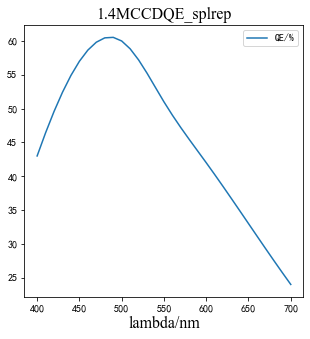

In [9]:

# 1.4MCCD量子效率三次样条插值
QE_data = scio.loadmat('data/Camera spectral response function/1.4MCCDQE_splrep.mat')['filters']
#rint(QE_data.shape)
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}
plt.figure(figsize=(5,5))
plt.title('1.4MCCDQE_splrep',font1)
plt.xlabel('lambda/nm',font1)
plt.plot(np.arange(400,710,10),QE_data)
plt.legend(['QE/%'])
#plt.savefig(img_path_data + '1.4MCCDQE_splrep.png')
plt.show()
QE_data = QE_data.reshape(-1,31)[-1]/100
wavelength_m = np.arange(400,710,10) # 10**-9m
all_filter = QE_data*wavelength_m # 波长和QE乘积



print(all_img_list[0])

## 测试数据集
list_MRAE = list_MRAELoss()
list_MSE = list_MSELoss()

path = all_img_list[0]
origin_img = h5py.File(path,'r')       
print(origin_img.keys())
rad = origin_img['rad'][:].transpose(1,2,0) # 1390x1300x31
rgb = origin_img['rgb'][:].transpose(2,1,0) # 1390x1300x3
#########################################################
print(rad.max(),rad.min())
rad[rad<=0]=1 # 防除零和负数
print(rad.max(),rad.min())
#########################################################
orgin_shape = rad.shape
pixel_W = torch.tensor(rad.reshape(-1,31)/all_filter*K*h_p*c_light/tc/pixel_S,device=device,dtype=dtype)
print(pixel_W.max(),pixel_W.min())


# MRAE图像

In [10]:
print(all_filter,K,h_p,c_light,tc,pixel_S)

[172.      190.33717 208.22886 225.4103  241.60004 256.5     269.79414
 281.1493  290.21616 296.62787 300.      300.10899 297.44884 292.75133
 286.81398 280.5     274.54392 268.93797 263.46906 257.90611 252.
 245.53903 238.51214 230.9643  222.94336 214.5     205.68966 196.5713
 187.20604 177.65913 168.     ] 200 6.626e-17 3 0.001 3.6e-11


In [ ]:
loss_MRAE = list_MRAELoss()
loss_T_limit=0.02
MRAE_limit = 0.1 # 0.22-0.45
# 两张训练图两张测试图
#plt.figure(figsize=(20,20))
font =  {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 25,
}
img_num = test_img_num+train_img_num # 图片展示就4张
fig,axs= plt.subplots(img_num,5,figsize=(5*5,img_num*5))

import matplotlib
import time
#vnorm = matplotlib.colors.Normalize(vmin=0, vmax=0.15)
##################################  拿图片测试
pixel_num = 0
time_start = time.time()
print('image restruct start.')
for i in range(img_num):
    # 第一列 RGB图像
    path = all_img_list[i]
    origin_img = h5py.File(path,'r')         
    rad = origin_img['rad'][:].transpose(1,2,0) # 1390x1300x31
    rgb = origin_img['rgb'][:].transpose(2,1,0) # 1390x1300x3
    rad[rad<=0]=1 # 防除零和负数
    #print(rad.shape)
    ax0 = axs[i,0].imshow(rgb)
    if i==0:
        axs[i,0].set_title("RGB",font)
    axs[i,0].set_xticks(())
    axs[i,0].set_yticks(())
    del rgb,origin_img
   
    # 保留原始图片的分辨率信息
    orgin_shape = rad.shape
    pixel_W = torch.tensor(rad.reshape(-1,31)/all_filter*K*h_p*c_light/tc/pixel_S,device=device,dtype=dtype)
    pixel_num = pixel_num+pixel_W.shape[0]
    del rad
    # 0
    BatchSize = orgin_shape[1] # 以一行的像素数目为一个批次输出网络的像素数目
    for batch in range(orgin_shape[0]):
        ## 计算每个批次的误差
        #Output_pixel0mid = hybnet_0(pixel_lm[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test),device_test)
        #MRAE_pixel0mid = np.round(loss_MRAE(Output_pixel0mid , pixel_lm[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test)).to('cpu').detach().numpy(),4)
        #Output_pixel16mid = hybnet_16(pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test),device_test)
        #MRAE_pixel16mid = np.round(loss_MRAE(Output_pixel16mid , pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test)).to('cpu').detach().numpy(),4)
        Output_pixel4mid = hybnet_4(pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test),device_test)
        MRAE_pixel4mid = np.round(loss_MRAE(Output_pixel4mid , pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test)).to('cpu').detach().numpy(),4)
        Output_pixel9mid = hybnet_9(pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test),device_test)
        MRAE_pixel9mid = np.round(loss_MRAE(Output_pixel9mid , pixel_W[BatchSize*batch:BatchSize+BatchSize*batch ,:].to(device_test)).to('cpu').detach().numpy(),4)
        ## 误差累加
        if batch ==0:
            #MRAE_pixel0 = MRAE_pixel0mid
            #MRAE_pixel16 = MRAE_pixel16mid
            #print(MRAE_pixel16.shape)
            MRAE_pixel4 = MRAE_pixel4mid
            MRAE_pixel9 = MRAE_pixel9mid
        else:
            #MRAE_pixel0 = np.concatenate([MRAE_pixel0,MRAE_pixel0mid])
            #MRAE_pixel16 = np.concatenate([MRAE_pixel16,MRAE_pixel16mid])
            MRAE_pixel4 = np.concatenate([MRAE_pixel4,MRAE_pixel4mid])
            MRAE_pixel9 = np.concatenate([MRAE_pixel9,MRAE_pixel9mid])
        del MRAE_pixel4mid,MRAE_pixel9mid

    # 恢复图像维度
    #MRAE_pixel16 = np.flip(MRAE_pixel16.reshape(orgin_shape[0],orgin_shape[1],1),0)
    new_MRAE_pixel9 = np.flip(MRAE_pixel9.reshape(orgin_shape[0],orgin_shape[1],1),0)
    new_MRAE_pixel4 = np.flip(MRAE_pixel4.reshape(orgin_shape[0],orgin_shape[1],1),0)
    
    #  第二列 2x2方案  
    ax1 = axs[i,1].imshow(new_MRAE_pixel4,cmap='Accent_r',vmin=0, vmax=MRAE_limit)
    if i==0:
        axs[i,1].set_title("2x2 MRAE",font)
    axs[i,1].set_yticks(())
    axs[i,1].set_xticks(())
    #############################################################
    plt.tight_layout()
    
    ax2 = axs[i,2].imshow(new_MRAE_pixel9,cmap='Accent_r',vmin=0, vmax=MRAE_limit)
    if i==0:
        axs[i,2].set_title("3x3 MRAE",font)
    axs[i,2].set_yticks(())
    axs[i,2].set_xticks(())
    plt.tight_layout()
    #############################################################
    del new_MRAE_pixel9,new_MRAE_pixel4
    
    # 第四列2x2 直方图
    plt.subplot(img_num,5,i*5+4)
    #mid_pixel = np.sort(MRAE_pixel4)
    MRAE_pixel4.sort()
    draw_hist(MRAE_pixel4,0,
              0,0,0,0,fsize=25,loss_T=loss_T_limit,bar_num=int((0.22-0)/0.001))   # 直方图展示
    if i==0:
        plt.title("2x2 MRAE hist",font)
    plt.tight_layout()
    # 第五列3x3 直方图
    plt.subplot(img_num,5,i*5+5)
    MRAE_pixel9.sort()

    draw_hist(MRAE_pixel9,0,
              0,0,0,0,fsize=25,loss_T=loss_T_limit,bar_num=int((0.22-0)/0.001))   # 直方图展示
    if i==0:
        plt.title("3x3 MRAE hist",font)
        plt.xlabel('MRAE',font)
        plt.ylabel('pixel num',font)
    plt.tight_layout()
    #############################################################
    del MRAE_pixel4,MRAE_pixel9
print('image restruct over.')
print('spend time = %ds,average time for 1million pixel =%ds '%((time.time()-time_start),(time.time()-time_start)/pixel_num*10**6))
########################################### 拿像素训练集测试 算了
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15,0.02, 0.7])
cb=fig.colorbar(ax1,ax=axs,cax=cbar_ax)
cb.ax.tick_params(labelsize=25)


fig.savefig(img_path_test+'%d张训练集+%d张测试集的MRAE（波长平均）灰度图onlyICVL_考虑峰谷数目修改NET和loss_loss修改函数和系数_图像合并.png'%(train_img_num,test_img_num))
#del MRAE_pixel0,MRAE_pixel1,MRAE_pixel4,MRAE_pixel9
plt.show()
#plt.savefig(img_path_test+'2张训练集+2张测试集的MRAE（波长平均）灰度图.png')

# MRAE直方图

4


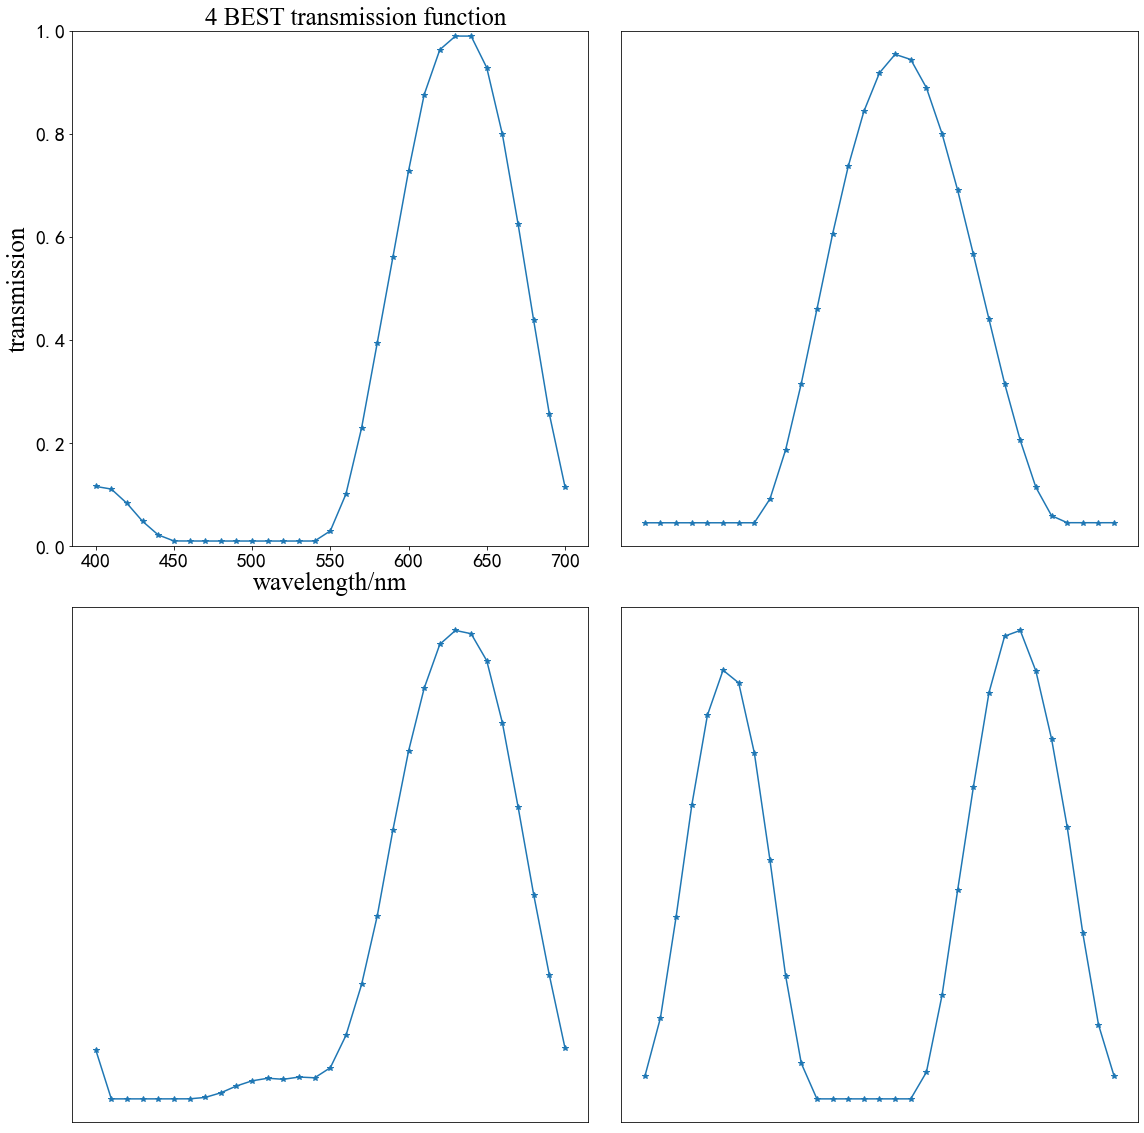

9


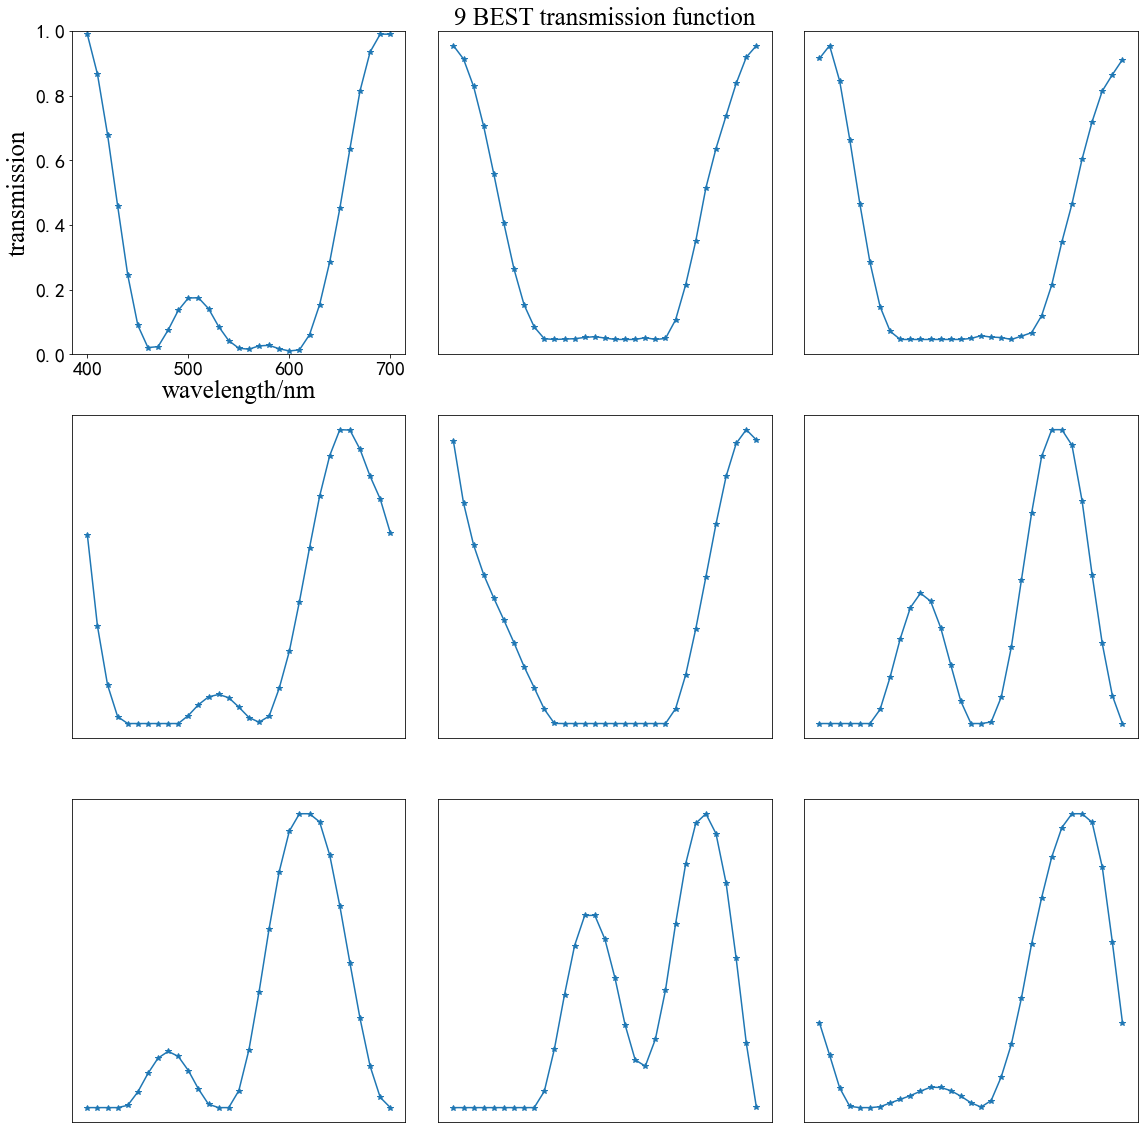

In [12]:
font =  {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 25,
}
filter_num = [4,9]
for i in filter_num:
    print(i)
    plt.figure(figsize=(16,16))
    if i==4:
        filter_T = hybnet_4.show_BESTFs_T().to('cpu').detach().numpy()
        title_j = [0,1]
    elif i==9:
        filter_T = hybnet_9.show_BESTFs_T().to('cpu').detach().numpy()
        title_j = [1,0]
    elif i==16:
        filter_T = hybnet_16.show_BESTFs_T().to('cpu').detach().numpy()
        title_j = [1,1]
    
    for j in range(i):
        plt.subplot(int(i**0.5),int(i**0.5),j+1)
        plt.plot(wavelength_m,filter_T[:,j],'-*')
        plt.tight_layout()
        if j==title_j[0]:
            if title_j[1]==0:
                plt.title("%d BEST transmission function"%(i),font)
            elif title_j[1]==1:
                plt.title("        %d BEST transmission function"%(i),font)
        if j==0:
            plt.ylim(0,1)
            plt.xlabel('wavelength/nm',font)
            plt.ylabel('transmission',font)
            plt.tick_params(labelsize = 20)
        else:
            plt.yticks(())
            plt.xticks(())

    plt.savefig(img_path_test+'%d个随机滤波片的透过率函数onlyICVL_考虑峰谷数目修改NET和loss_loss修改函数和系数_图像合并.png'%(i))
    plt.show()